# Program - plot cn_map using cartopy

**Purpose**


**Content**
- read TaiESM1 and CERES data
- using an xarray function, interp_like, to interpolate data on one lat/lon grid to another lat/lon grid
- plot cn_map using cartopy

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** May 24, 2023

**Reference program:**

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
import read_data as read_data

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read data

### TaiESM1

In [2]:
choice = "rsut_Amon_TaiESM1_amip-hist_r1i1p1f1_1979_2014"
ds_TaiESM1 = read_data.read_TaiESM_data(choice)
#ds_TaiESM1

rsut_TaiESM1_mean = ds_TaiESM1.rsut.mean("time")

### CERES
#### Interpolate CERES data on TaiESM grid
- using xarray, interp_like
- https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp_like.html
- the source_data and target_data better are (lat, lon), no time dimension

In [3]:
choice = "CERES_EBAF-TOA_Ed4.2_Subset_200101-201412"
ds_ceres = read_data.read_CERES_data(choice)
ds_ceres

#--- interpolation
sw_all_CERES_mean = ds_ceres.toa_sw_all_mon.mean("time").interp_like(rsut_TaiESM1_mean, kwargs={"fill_value": "extrapolate"})

## Define plotting function

### add_lon_cyclic

In [7]:
#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
def add_lon_cyclic(var): 
    var_return, lon_cyclic = cutil.add_cyclic_point(var, coord=var.lon)  

    return var_return, lon_cyclic

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    sw_all_CERES_mean_plot, lon_CERES = add_lon_cyclic(sw_all_CERES_mean)


### cn_attrs

In [8]:
def cn_attrs(varname, var):

    #--- 
    if (varname == "TOA_SW"):
        cn_levels = 15
        cmap="viridis"
        #long_name = var.standard_name
        long_name = "TOA outgoing SW flux"
        units = var.units
        cbar_label = long_name+" ("+units+")"

    elif (varname == "TOA_SW_diff"):
        cn_levels = np.array([-50, -40, -30, -20, -15, -10, -5, 0, 
                                 5, 10, 15, 20, 30, 40, 50])
        cmap="seismic_r"
        #long_name = var.standard_name
        long_name = "TOA outgoing SW flux diff"
        units = var.units
        cbar_label = long_name+" ("+units+")"
        
    else:
        cn_levels = 15
        cmap = "viridis"
        cbar_label = "Var (units)"
        long_name = "var"
        units="N/A"
    
    return cn_levels, cmap, long_name, units, cbar_label

#----------
# do test
#----------

#do_test=True
do_test=False

if (do_test):
    
    varname = "TOA_SW"
    var_tmp = xr.DataArray(1)
    var_tmp.attrs['standard_name']="ggg"
    var_tmp.attrs['units']="KK"
    cn_levels, cmap, long_name, units, cbar_label = cn_attrs(varname, var=var_tmp)
    
    print(long_name)

### plot_cn_map

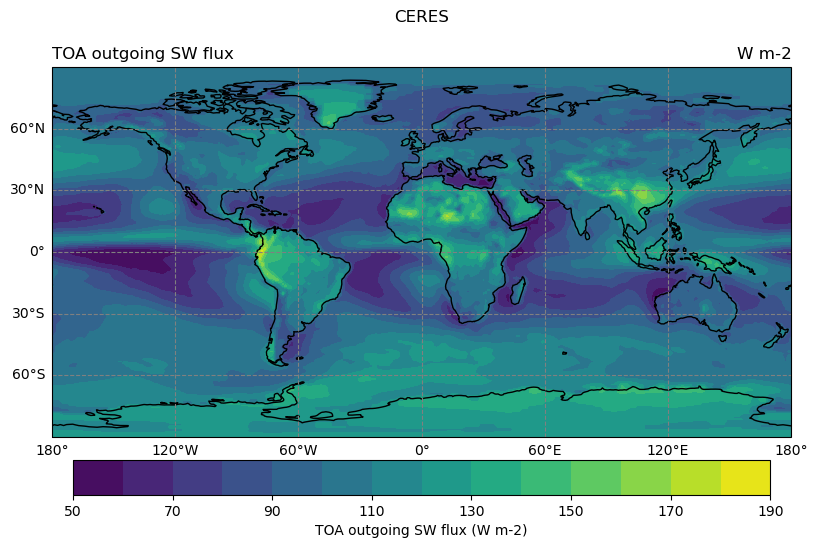

In [9]:
def plot_cn_map(ax, map_projection,
                var, varname, title, 
                cmap = "viridis", orientation='horizontal', label='Some units', shrink = 0.9, pad=0.05,
                do_add_lon_cyclic = True): 
    
    """
    ----------------------
    Description:


    Input arguments:


    Return:


    Example:
      import yhc_module as yhc
       = yhc.()

    Date created: 2023-05-25
    ----------------------
    """


    func_name = ""

    #--- adding a cyclic point in lon
    if (do_add_lon_cyclic): 
        var_plot, lon_plot = add_lon_cyclic(var)
    else:
        var_plot = var.copy()
        lon_plot = var_plot.lon
    
    #--- plot cn_map & a colorbar
    cn_levels, cmap, long_name, units, cbar_label = cn_attrs(varname = varname, var=var)
    cn_map_var = ax.contourf(lon_plot, var.lat, var_plot, levels = cn_levels, cmap=cmap, transform=map_projection)
   
    #--- add coast lines
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS)
    ax.set_global()

    #--- add grid lines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines

    # turn off labels on the top and right sides
    gl.top_labels = False
    gl.right_labels = False

    #--- add texts
    ax.set_title(title, y=1.1)
    
    left_string = long_name
    right_string = units
    cbar_label = left_string+" ("+right_string+")"
    
    ax.set_title(left_string, loc='left')
    ax.set_title(right_string, loc='right')

    #--- plot colorbar
    if (isinstance(cn_levels, int)):
        cbar = plt.colorbar(cn_map_var, ax=ax, orientation=orientation, shrink=shrink, label=cbar_label, pad=pad)
    else:
        cbar = plt.colorbar(cn_map_var, ax=ax, orientation=orientation, shrink=shrink, label=cbar_label, ticks=cn_levels, pad=pad )

    
    return
    
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    map_projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=map_projection)
    title = "CERES"
    
    plot_cn_map (ax, map_projection, var = sw_all_CERES_mean, varname = "TOA_SW", title = "CERES")
    #plot_cn_map (ax, map_projection, var = rsut_TaiESM1_mean, title = "TaiESM1")
    
    #var_TaiESMmCERES = rsut_TaiESM1_mean - sw_all_CERES_mean
    #plot_cn_map (ax, map_projection, var = var_TaiESMmCERES, varname = "TOA_SW_diff", title = "TaiESM1 - CERES")


## Plot

### TOA outgoing SW flux

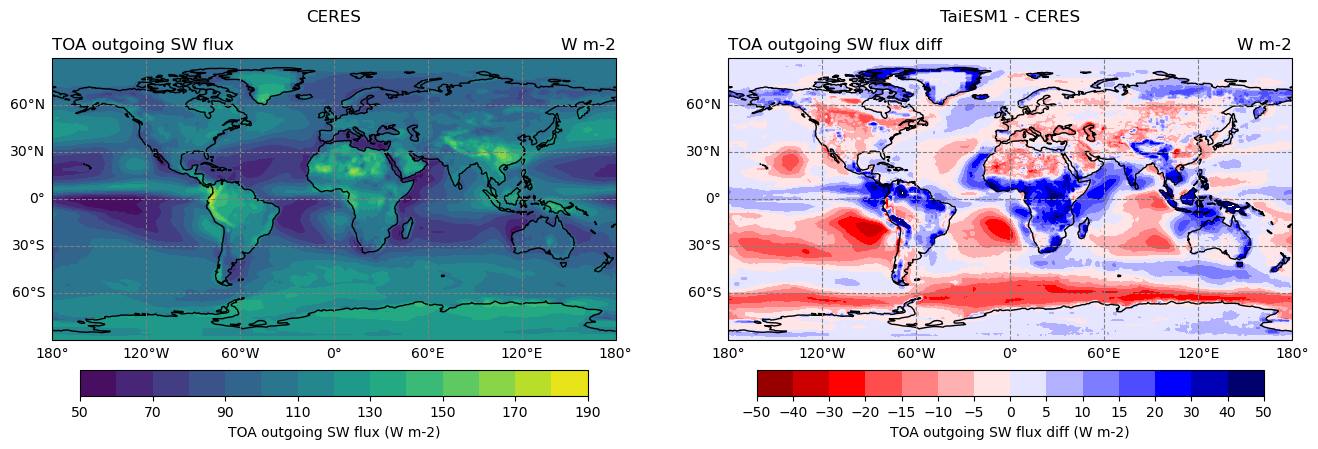

In [11]:
map_projection = ccrs.PlateCarree(central_longitude=0)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8), subplot_kw={'projection': map_projection})   # 2 row, 1 column

#--- CERES
plot_cn_map (ax1, map_projection, var = sw_all_CERES_mean, varname = "TOA_SW", title = "CERES")

#--- TaiESM1 - CERES
var_TaiESMmCERES = rsut_TaiESM1_mean - sw_all_CERES_mean
plot_cn_map (ax2, map_projection, var = var_TaiESMmCERES, varname = "TOA_SW_diff", title = "TaiESM1 - CERES")

